# Rough Draft Workbook for Zillow Project

In [1]:
# Basics
import numpy as np
import pandas as pd
import os
import scipy.stats as stats
from pydataset import data

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Models and Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Custom
import env
import wrangle_prep as wp

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Make sure we can see the full scale of the data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# set up my variables
df = wp.wrangle_zillow()
df.head(3)

Saving to .csv


,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
0,14297519,3.5,4.0,6.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,6.059063e+07,53571.0,1286.0,96978.0,0.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,0.025595,2017-01-01
1,17052889,1.0,2.0,6.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,6.111001e+07,13091.0,2061.0,97099.0,5.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,0.055619,2017-01-01
2,14186244,2.0,3.0,6.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,6.059022e+07,21412.0,1286.0,97078.0,6.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,0.005383,2017-01-01


In [3]:
# since were looking at logerror, lets feature engineer around that first
# first with the addition of an absolute value column
df['abs_logerror'] = abs(df.logerror)

# second, an indication of whether the logerror was low or high
df['logerror_direction'] = np.where(df.logerror < 0, 'low', 'high')

# get county names from fips
df['county'] = pd.cut(df.fips, bins=[0, 6037.0, 6059.0, 6111.0], 
                             labels = ['Los Angeles County', 'Orange County',
                             'Ventura County'])

# lastly property age, which helps with visualization
df.year_built = df.yearbuilt.astype(int)
df['age'] = 2017 - df.yearbuilt

df.head(4)

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,abs_logerror,logerror_direction,county,age
0,14297519,3.5,4.0,6.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,6.059063e+07,53571.0,1286.0,96978.0,0.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,0.025595,2017-01-01,0.025595,high,Orange County,19.0
1,17052889,1.0,2.0,6.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,6.111001e+07,13091.0,2061.0,97099.0,5.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,0.055619,2017-01-01,0.055619,high,Ventura County,50.0
2,14186244,2.0,3.0,6.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,6.059022e+07,21412.0,1286.0,97078.0,6.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,0.005383,2017-01-01,0.005383,high,Orange County,55.0
3,12177905,3.0,4.0,8.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,6.037300e+07,396551.0,3101.0,96330.0,0.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,-0.103410,2017-01-01,0.103410,low,Los Angeles County,47.0


In [4]:
# Verify
df.shape

(67977, 26)

In [5]:
# train, validate, test split
train, validate, test = wp.split_data(df)

train <> (38066, 26)
validate <> (16315, 26)
test <> (13596, 26)


In [6]:
# Data for modeling
x_train = train.drop(columns=['logerror'])
y_train = train.logerror

x_validate = validate.drop(columns=['logerror'])
y_validate = validate.logerror

x_test = test.drop(columns=['logerror'])
y_test = test.logerror

# Scaling
x_train_scaled, x_validate_scaled, x_test_scaled = wp.scale_data(x_train, x_validate, x_test)

train_scaled <> (38066, 25)
validate_scaled <> (16315, 25)
test_scaled <> (13596, 25)


# Initial Exploration

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67977 entries, 0 to 77573
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   parcelid                      67977 non-null  int64   
 1   bathroomcnt                   67977 non-null  float64 
 2   bedroomcnt                    67977 non-null  float64 
 3   buildingqualitytypeid         67977 non-null  float64 
 4   calculatedfinishedsquarefeet  67977 non-null  float64 
 5   fips                          67977 non-null  float64 
 6   latitude                      67977 non-null  float64 
 7   longitude                     67977 non-null  float64 
 8   lotsizesquarefeet             67977 non-null  float64 
 9   rawcensustractandblock        67977 non-null  float64 
 10  regionidcity                  67977 non-null  float64 
 11  regionidcounty                67977 non-null  float64 
 12  regionidzip                   67977 non-null  

In [8]:
df.describe()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,abs_logerror,age
count,6.797700e+04,67977.000000,67977.000000,67977.000000,67977.000000,67977.000000,6.797700e+04,6.797700e+04,6.797700e+04,6.797700e+04,67977.000000,67977.000000,67977.000000,67977.000000,67977.000000,6.797700e+04,6.797700e+04,67977.0,6.797700e+04,67977.000000,67977.000000,67977.000000,67977.000000
mean,1.301859e+07,2.202208,2.979361,6.314400,1675.335643,6049.441002,3.400452e+07,-1.181922e+08,2.785835e+04,6.049738e+07,33629.109905,2497.538903,96599.725907,1.602057,1968.828486,1.633991e+05,4.128805e+05,2016.0,2.494814e+05,5062.504630,0.016567,0.066315,48.171514
std,2.138710e+06,0.841592,0.980254,1.316425,764.510956,20.981742,2.689044e+05,3.618898e+05,1.204185e+05,2.082548e+05,46958.881196,814.755364,3314.077112,2.907933,22.792962,1.267090e+05,3.029315e+05,0.0,2.225690e+05,3494.811018,0.164081,0.150995,22.792962
min,1.071186e+07,0.000000,0.000000,1.000000,128.000000,6037.000000,3.333953e+07,-1.194753e+08,2.360000e+02,6.037101e+07,3491.000000,1286.000000,95982.000000,0.000000,1878.000000,4.400000e+01,3.254000e+03,2016.0,1.610000e+02,19.920000,-4.655420,0.000002,1.000000
25%,1.153706e+07,2.000000,2.000000,6.000000,1156.000000,6037.000000,3.380559e+07,-1.184068e+08,6.000000e+03,6.037400e+07,12447.000000,1286.000000,96212.000000,0.000000,1954.000000,8.177700e+04,1.986290e+05,2016.0,7.919000e+04,2620.300000,-0.023628,0.013397,31.000000
50%,1.260270e+07,2.000000,3.000000,6.000000,1488.000000,6037.000000,3.401119e+07,-1.181600e+08,7.313000e+03,6.037621e+07,25218.000000,3101.000000,96412.000000,0.000000,1970.000000,1.309070e+05,3.466180e+05,2016.0,1.960000e+05,4277.300000,0.006325,0.030823,47.000000
75%,1.426033e+07,3.000000,4.000000,7.000000,1996.000000,6059.000000,3.417698e+07,-1.179139e+08,1.044100e+04,6.059052e+07,45457.000000,3101.000000,96993.000000,0.000000,1986.000000,2.048630e+05,5.389580e+05,2016.0,3.492460e+05,6506.950000,0.037433,0.064689,63.000000
max,1.629608e+08,10.000000,11.000000,12.000000,8251.000000,6111.000000,3.481877e+07,-1.175723e+08,6.971010e+06,6.111009e+07,396556.000000,3101.000000,399675.000000,14.000000,2016.000000,1.646927e+06,2.090230e+06,2016.0,1.786325e+06,19997.540000,3.394544,4.655420,139.000000


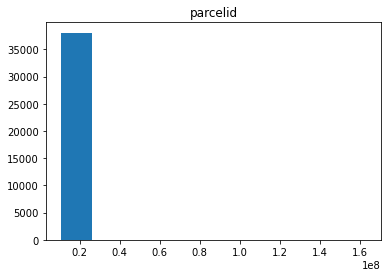

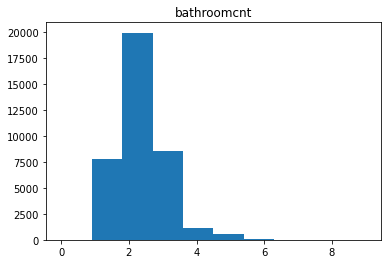

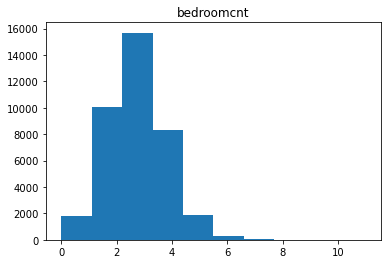

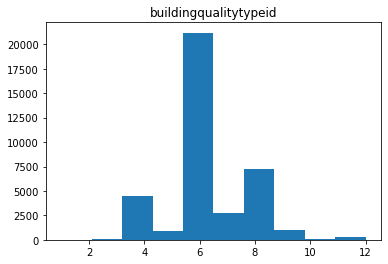

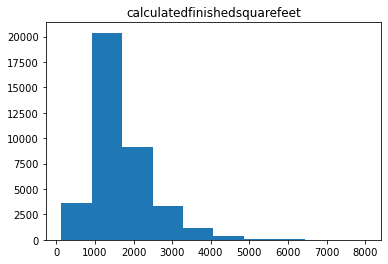

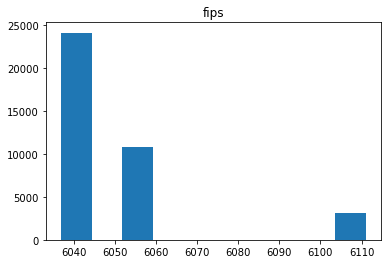

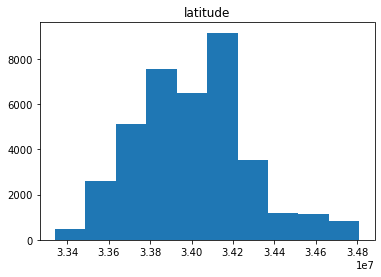

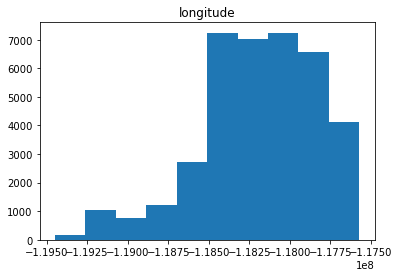

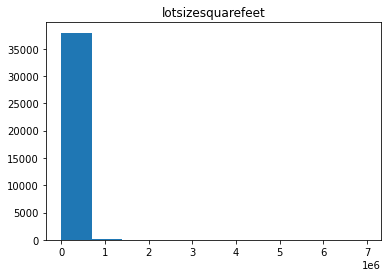

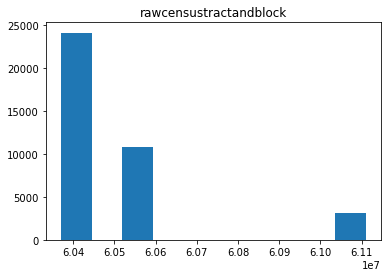

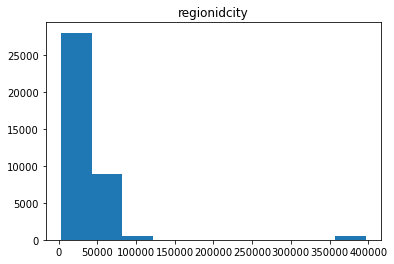

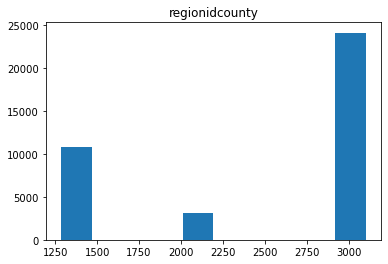

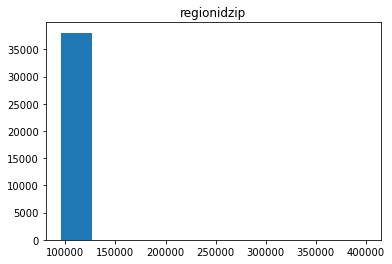

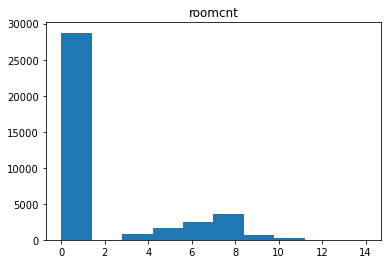

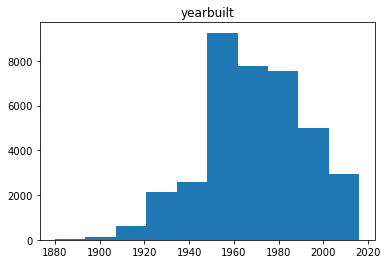

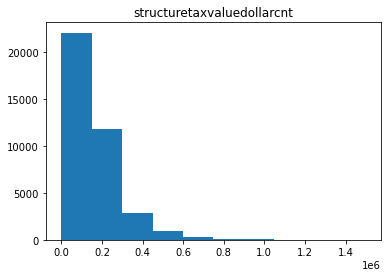

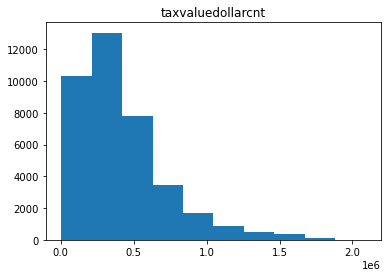

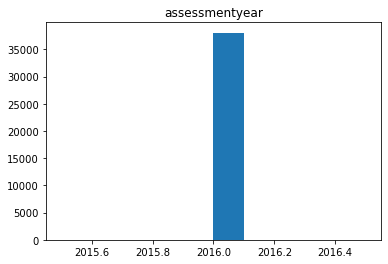

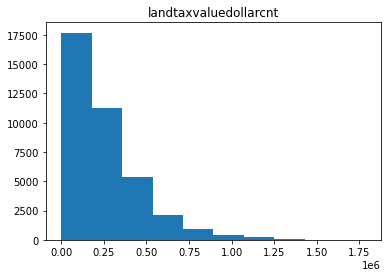

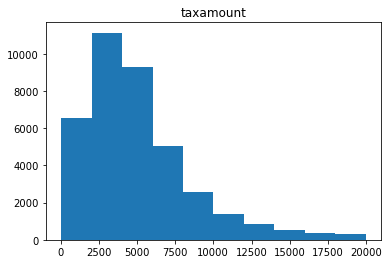

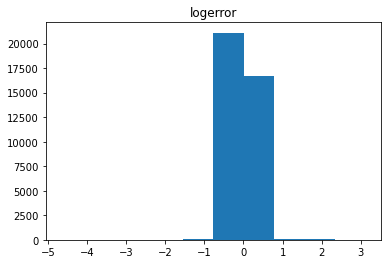

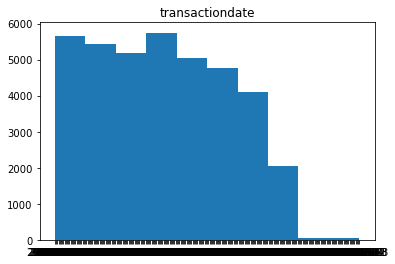

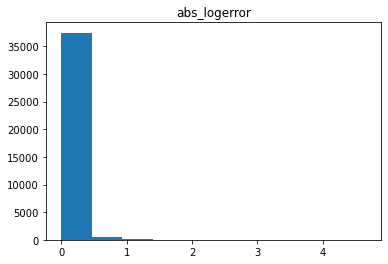

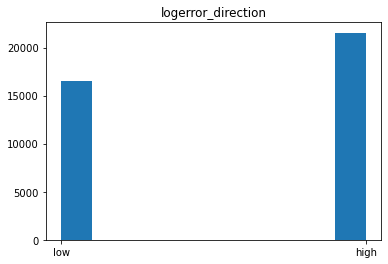

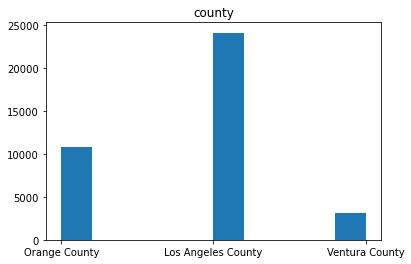

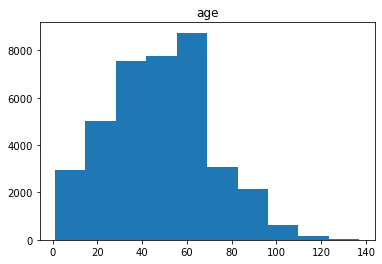

In [9]:
# Univariate distribution
for col in train.columns:
    plt.hist(train[col])
    plt.title(col)
    plt.show()

# Takeaways
- Mostly normal distribution among features

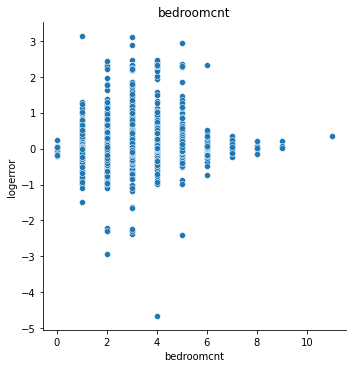

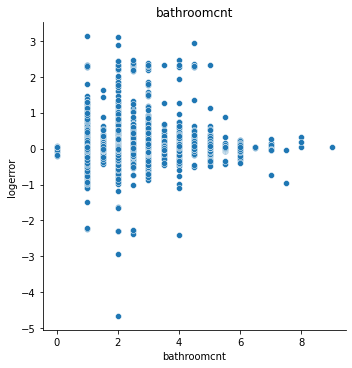

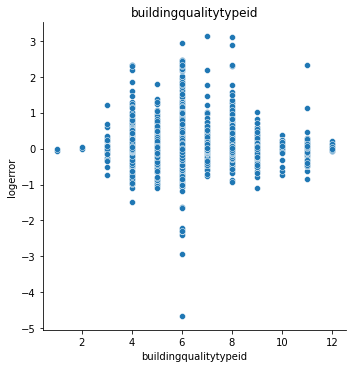

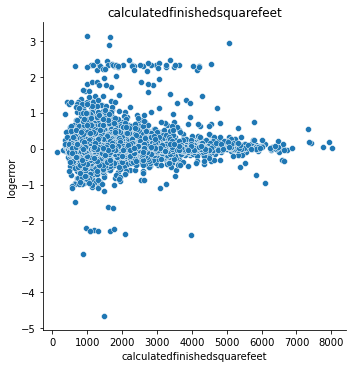

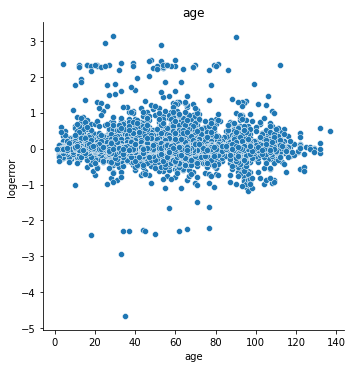

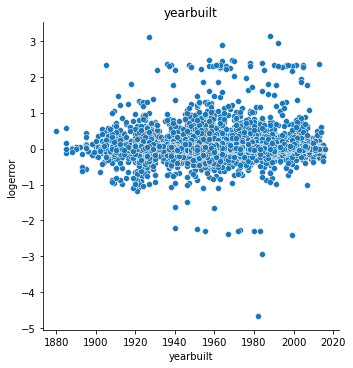

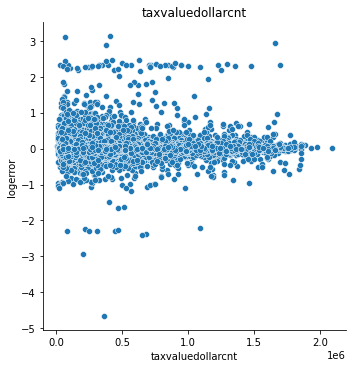

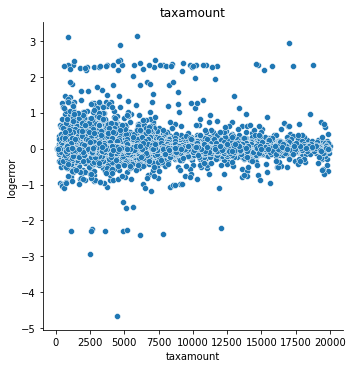

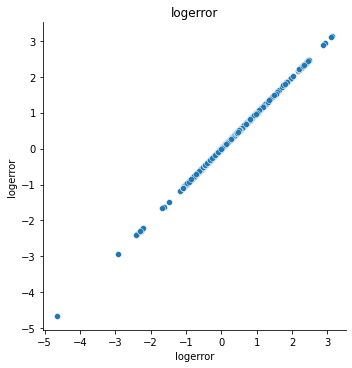

In [10]:
# Bivariate and Multivariate

exp_columns = ['bedroomcnt', 'bathroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'age', 'yearbuilt', 'taxvaluedollarcnt', 'taxamount', 'logerror']

for col in train[exp_columns]:
    sns.relplot(x=train[col], y=train.logerror)
    plt.title(col)
    plt.show()

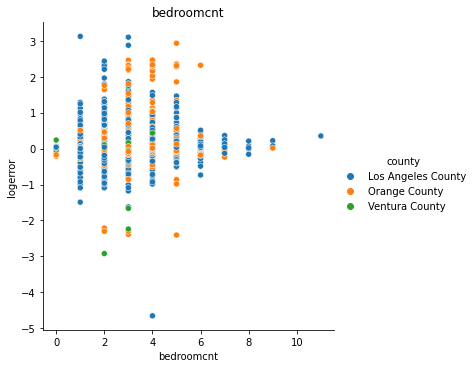

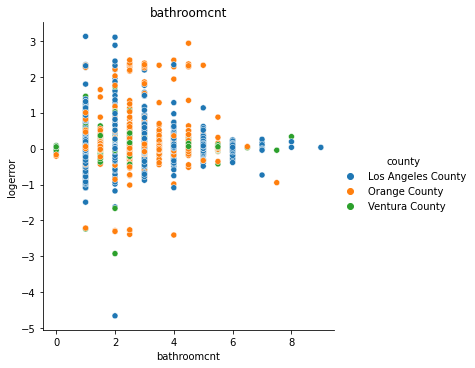

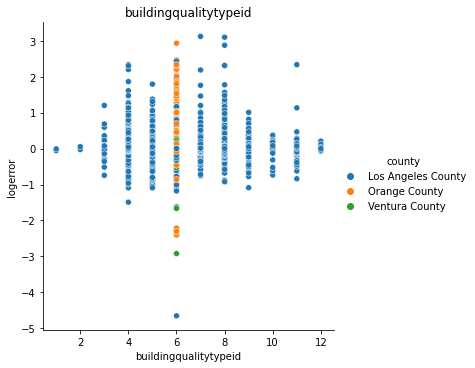

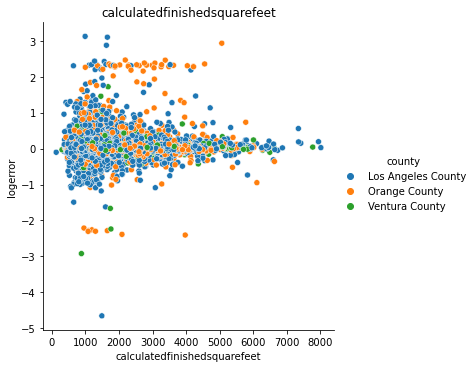

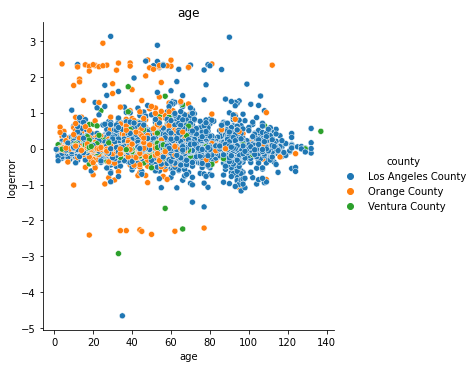

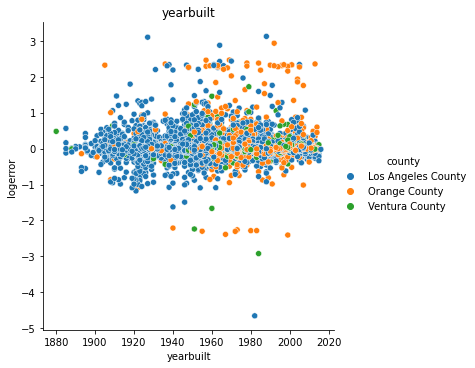

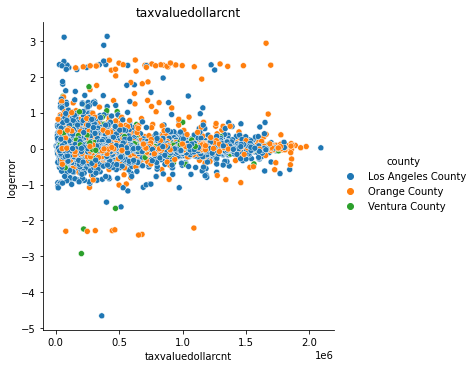

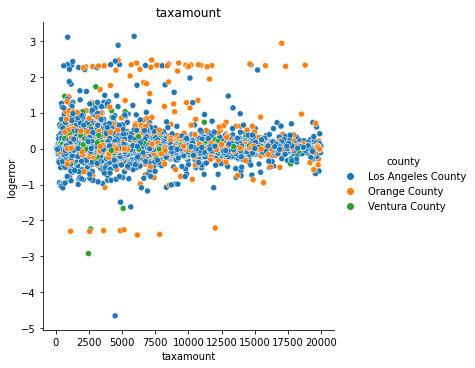

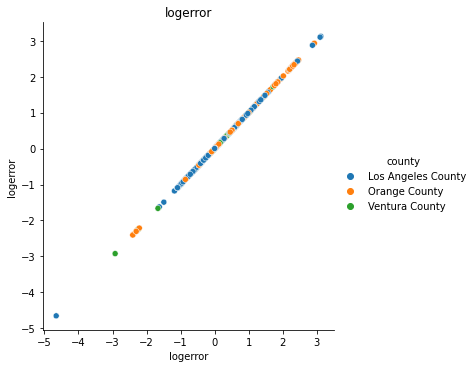

In [11]:
for col in train[exp_columns]:
    sns.relplot(x=train[col], y=train.logerror, hue=train.county)
    plt.title(col)
    plt.show()

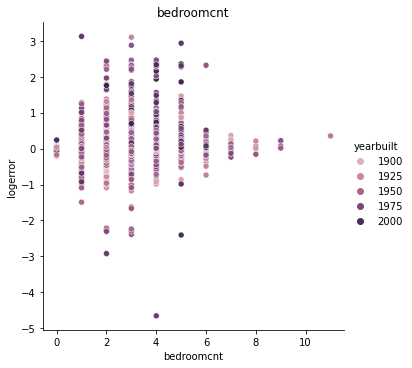

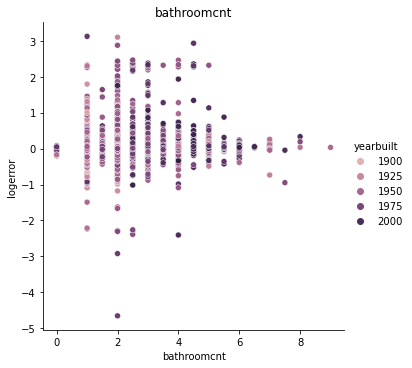

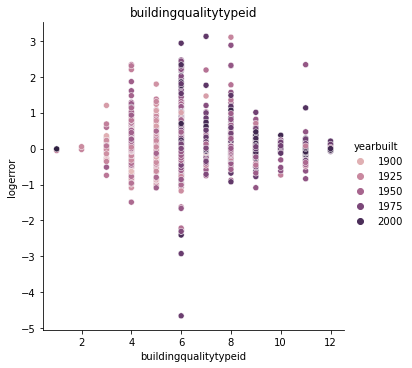

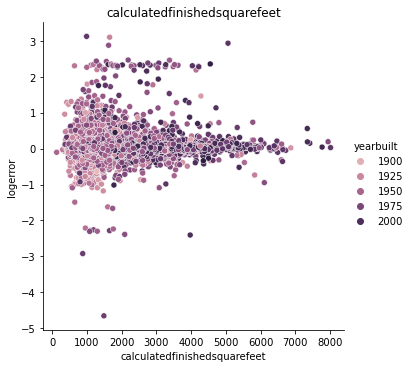

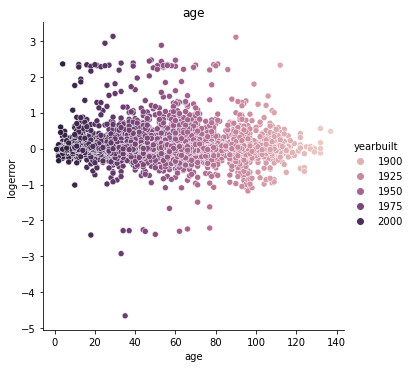

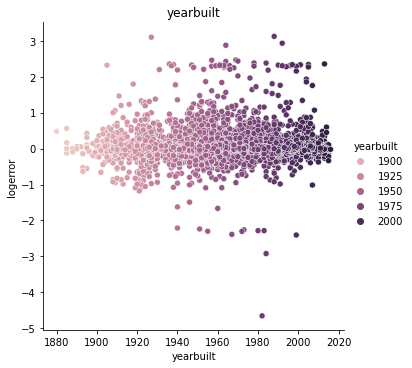

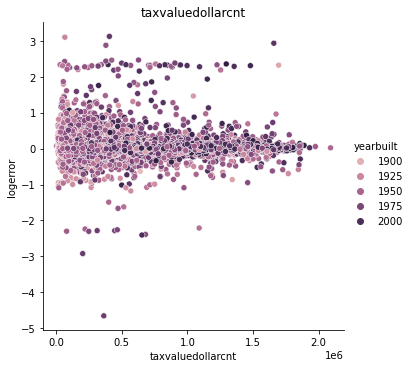

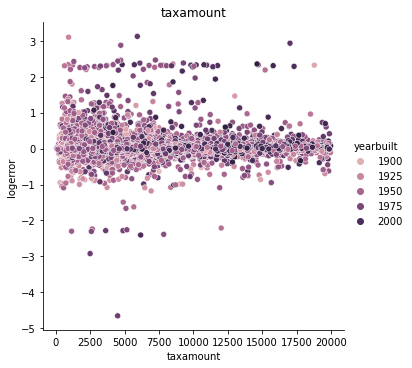

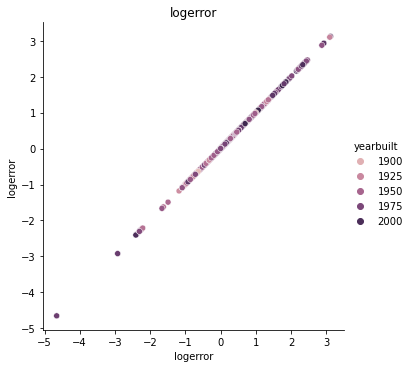

In [12]:
for col in train[exp_columns]:
    sns.relplot(x=train[col], y=train.logerror, hue=train.yearbuilt)
    plt.title(col)
    plt.show()

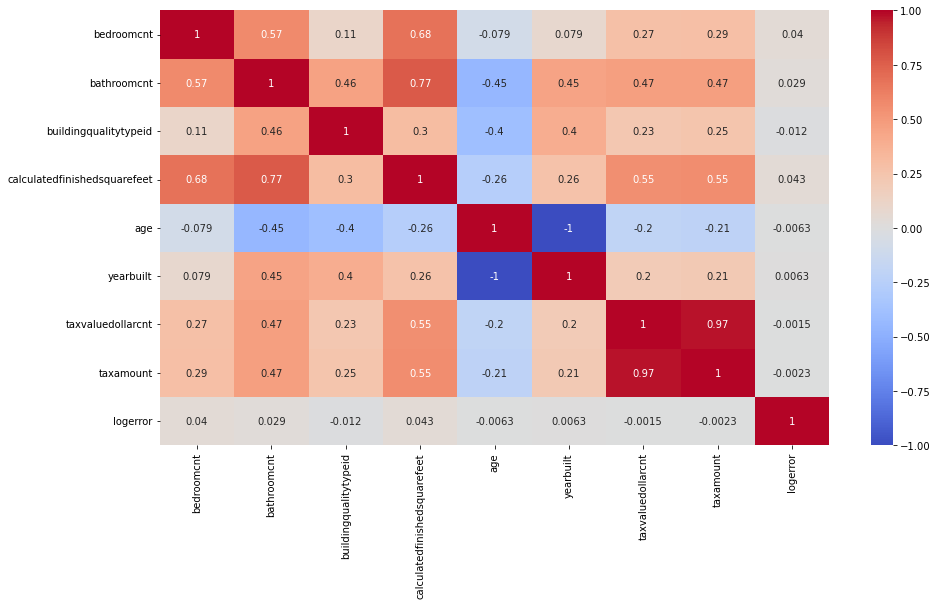

In [13]:
# Heatmap
plt.figure(figsize = (15,8))
sns.heatmap(train[exp_columns].corr(), cmap='coolwarm', center=0, annot=True)
plt.show()

# Takaways
- Newer homes tend to have higher logerror than older homes
- Higher taxamounts seem to have lower rates of logerror
- Might be worth breaking up homes by age
- LA county (fips 6037) was the only county to track buildingqualitytypeid
- Refrencing the heatmap, calulatedfinishedsquarefeet was the feature that showed the most impact on log error
---------
## Questions to explore and verify:
- Is there a relationship between logerror and age?
- Does the county(fips) influence the logerror?
- Does size of the property infuence the logerror?
- Can taxamount or taxvaluedollarcnt be used to calculate logerror?
----
### Question 1 
#### Is there a relationship between logerror and age?

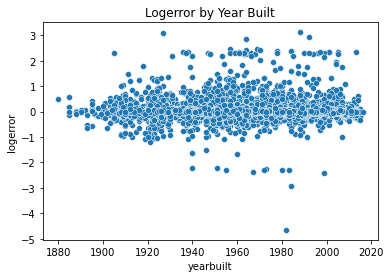

In [14]:
sns.scatterplot(data=train, y='logerror', x='yearbuilt')
plt.title('Logerror by Year Built')
plt.show()

In [15]:
stats.ttest_ind(train.yearbuilt, train.logerror,
                equal_var=True)

Ttest_indResult(statistic=16819.059485896472, pvalue=0.0)

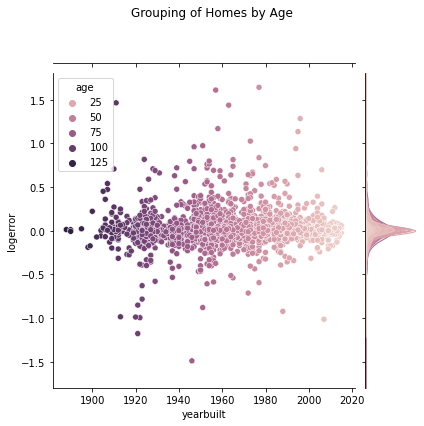

In [16]:
# logerror seems to be better before the 1950's

sample = train.sample(5000)

sns.jointplot('yearbuilt', 'logerror', data=sample, kind='scatter', hue='age', ylim=(-1.8, 1.8))
plt.suptitle('Grouping of Homes by Age')

plt.show()


In [17]:
# H0: Homes built before 1950 have no difference in logerror than homes built past 1950
# Ha: Homes built before 1950 have significant differences in logerror than homes built past 1950

stats.levene(train[train.yearbuilt <= 1950].logerror, 
             train[train.yearbuilt > 1950].logerror
            )

LeveneResult(statistic=313.67364588868776, pvalue=6.604776915086508e-70)

In [18]:
# Can assume Equal Varience
stats.ttest_ind(train[train.yearbuilt <= 1950].logerror,
                train[train.yearbuilt >1950].logerror,
                equal_var=True)

Ttest_indResult(statistic=-2.3778230931149356, pvalue=0.01742008660265203)

### The T-Test confirms we can reject the null hypothesis
- Alternative Hypothesis(Ha): Homes built before 1950 have significant differences in logerror than homes built past 1950
-------
# Question 2
- Does the county(fips) influence the logerror?

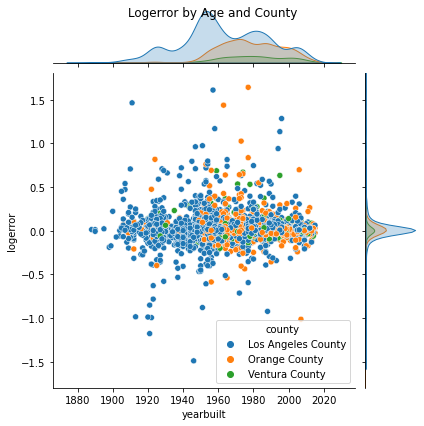

In [19]:
# Lets compare fips on our last graph
sns.jointplot('yearbuilt', 'logerror', data=sample, kind='scatter', hue='county', ylim=(-1.8, 1.8))
plt.suptitle('Logerror by Age and County')

plt.show()

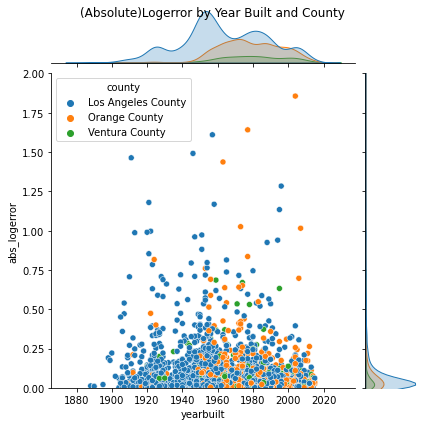

In [20]:
# different perspective
sns.jointplot('yearbuilt', 'abs_logerror', data=sample, hue='county', kind='scatter', ylim=(0,2))

plt.suptitle('(Absolute)Logerror by Year Built and County')
plt.show()


In [21]:
# confirm with stats

# H0: LA County propeties has no significant impact on logerror than Orange and Ventura Counties
# Ha: LA County propeties does have a significant impact on logerror than Orange and Ventura Counties

stats.levene(train[train.fips == 6037].logerror, 
             train[train.fips != 6037].logerror
            )

LeveneResult(statistic=35.71270627924118, pvalue=2.306969287718477e-09)

In [22]:
# Can assume Equal Variance
# T-test
stats.ttest_ind(train[train.fips == 6037].logerror,
                train[train.fips != 6037].logerror,
                equal_var=True)

Ttest_indResult(statistic=-3.2780584817626086, pvalue=0.001046174044004433)

### The T-Test confirms we can reject the null hypothesis¶

   - Alternative Hypothesis(Ha): Properties in LA County have significant differences in logerror vs properties in other counties.
------
# Question 3
   - Does size of the property infuence the logerror?

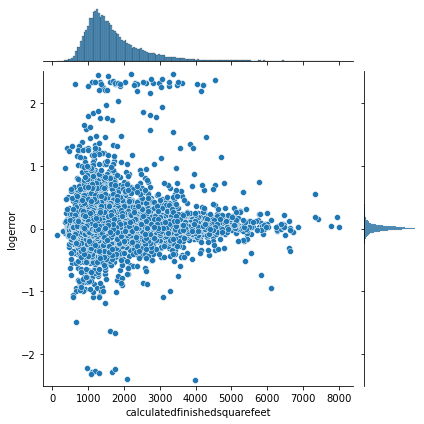

In [23]:
# I'm going to look particularly at calulatedfinishedsquarefeet
sns.jointplot(x='calculatedfinishedsquarefeet', y='logerror', data=train, ylim=(-2.5, 2.5))
plt.show()


## Takeaways
- Smaller homes definitely have a higher log error
- As home get larger in square feet the log error decreases, clearly indicating some kind of correlation(as forecasted by the heatmap earlier)

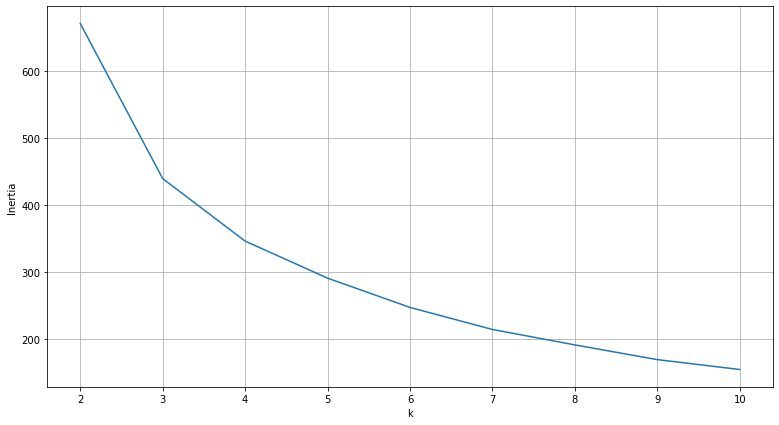

In [24]:
cols = ['calculatedfinishedsquarefeet', 'taxamount']
X = x_train_scaled[cols]

inertias = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertias[k] = kmeans.inertia_

pd.Series(inertias).plot(xlabel='k', ylabel='Inertia', figsize=(13, 7))
plt.grid()

In [25]:
# I'll go with a k value of 3 for my cluster

kmeans = KMeans(n_clusters=3).fit(X)
train['cluster_area_tax'] = kmeans.predict(X)
train.cluster_area_tax = train.cluster_area_tax.astype('category')

# means of each feature by cluster
train.groupby('cluster_area_tax').mean()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,abs_logerror,age
cluster_area_tax,,,,,,,,,,,,,,,,,,,,,,,
0,1.312706e+07,2.426888,3.223426,6.526631,1883.782635,6051.101523,3.399189e+07,-1.181961e+08,20102.850822,6.051374e+07,32721.856125,2426.510645,96600.043715,1.897795,1973.244867,198302.943405,5.339050e+05,2016.0,335602.058414,6476.442434,0.013870,0.057644,43.755133
1,1.290923e+07,1.873957,2.695361,6.057959,1329.196357,6048.039082,3.402467e+07,-1.181883e+08,33216.140391,6.048359e+07,34245.654003,2566.475242,96574.040030,1.410264,1964.417236,98852.076883,2.171593e+05,2016.0,118307.195314,2752.556322,0.018584,0.068799,52.582764
2,1.314886e+07,3.217420,3.735924,7.005551,2856.460481,6051.022205,3.394412e+07,-1.182075e+08,20965.902458,6.051269e+07,31664.765266,2394.033307,96601.921491,1.592123,1976.756807,396219.201692,1.082046e+06,2016.0,685826.342321,12972.935686,0.027504,0.081018,40.243193


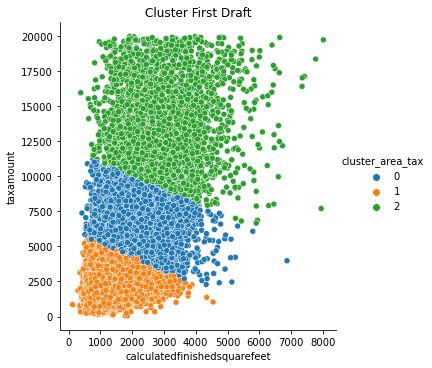

In [26]:
# Visualize clusters
sns.relplot(data=train, y='taxamount', x='calculatedfinishedsquarefeet', hue='cluster_area_tax')
plt.title('Cluster First Draft')

plt.show()

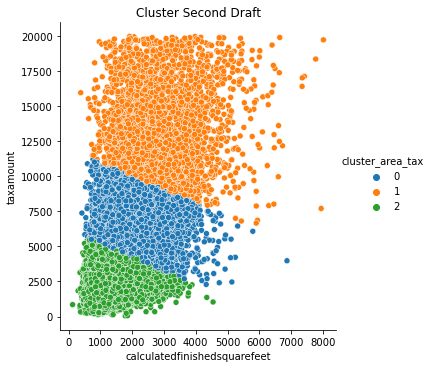

In [27]:
kmeans = KMeans(n_clusters=3).fit(X)
train['cluster_area_tax'] = kmeans.predict(X)
train.cluster_area_tax = train.cluster_area_tax.astype('category')

# visualize
sns.relplot(data=train, y='taxamount', x='calculatedfinishedsquarefeet', hue='cluster_area_tax')
plt.title('Cluster Second Draft')

plt.show()

In [28]:
train.groupby('cluster_area_tax').mean()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,abs_logerror,age
cluster_area_tax,,,,,,,,,,,,,,,,,,,,,,,
0,1.312706e+07,2.426888,3.223426,6.526631,1883.782635,6051.101523,3.399189e+07,-1.181961e+08,20102.850822,6.051374e+07,32721.856125,2426.510645,96600.043715,1.897795,1973.244867,198302.943405,5.339050e+05,2016.0,335602.058414,6476.442434,0.013870,0.057644,43.755133
1,1.314886e+07,3.217420,3.735924,7.005551,2856.460481,6051.022205,3.394412e+07,-1.182075e+08,20965.902458,6.051269e+07,31664.765266,2394.033307,96601.921491,1.592123,1976.756807,396219.201692,1.082046e+06,2016.0,685826.342321,12972.935686,0.027504,0.081018,40.243193
2,1.290923e+07,1.873957,2.695361,6.057959,1329.196357,6048.039082,3.402467e+07,-1.181883e+08,33216.140391,6.048359e+07,34245.654003,2566.475242,96574.040030,1.410264,1964.417236,98852.076883,2.171593e+05,2016.0,118307.195314,2752.556322,0.018584,0.068799,52.582764


## Takeaways
- There seems to be little change to the cluster after refitting
- Cluster 1 has the lowest logerror and abs_logerror, while the mean for other feature was not as useful
--------
# Continued Cluster Exploration 
- I know from my earlier exploration that age was an indicator
- I want to check with calculatedfinishedsquarefeet and taxamount as well, and then perhaps seperately

In [31]:
# features to make cluster with
cols = ['calculatedfinishedsquarefeet', 'taxamount', 'age']
X = x_train_scaled[cols]

# make it
kmeans = KMeans(n_clusters=3).fit(X)
train['cluster_area_tax_age'] = kmeans.predict(X)
train.cluster_area_tax_age = train.cluster_area_tax.astype('category')

# Visualize clusters
train.groupby('cluster_area_tax_age').mean()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,abs_logerror,age
cluster_area_tax_age,,,,,,,,,,,,,,,,,,,,,,,
0,1.312706e+07,2.426888,3.223426,6.526631,1883.782635,6051.101523,3.399189e+07,-1.181961e+08,20102.850822,6.051374e+07,32721.856125,2426.510645,96600.043715,1.897795,1973.244867,198302.943405,5.339050e+05,2016.0,335602.058414,6476.442434,0.013870,0.057644,43.755133
1,1.314886e+07,3.217420,3.735924,7.005551,2856.460481,6051.022205,3.394412e+07,-1.182075e+08,20965.902458,6.051269e+07,31664.765266,2394.033307,96601.921491,1.592123,1976.756807,396219.201692,1.082046e+06,2016.0,685826.342321,12972.935686,0.027504,0.081018,40.243193
2,1.290923e+07,1.873957,2.695361,6.057959,1329.196357,6048.039082,3.402467e+07,-1.181883e+08,33216.140391,6.048359e+07,34245.654003,2566.475242,96574.040030,1.410264,1964.417236,98852.076883,2.171593e+05,2016.0,118307.195314,2752.556322,0.018584,0.068799,52.582764


In [32]:
# Not great results.  Need to narrow my search
# features to make cluster with
cols = ['calculatedfinishedsquarefeet', 'age']
X = x_train_scaled[cols]

# make it
kmeans = KMeans(n_clusters=3).fit(X)
train['cluster_area_age'] = kmeans.predict(X)
train.cluster_area_age = train.cluster_area_age.astype('category')

# Visualize clusters
train.groupby('cluster_area_age').mean()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,abs_logerror,age
cluster_area_age,,,,,,,,,,,,,,,,,,,,,,,
0,1.212399e+07,1.638593,2.688699,5.392537,1446.608316,6039.290832,3.402504e+07,-1.182533e+08,8602.900426,6.039630e+07,44239.358635,2996.243070,96228.739019,0.318124,1928.686780,115944.831557,389307.544136,2016.0,273362.712580,4839.064825,0.012193,0.101582,88.313220
1,1.341184e+07,2.572214,2.967769,6.801917,1870.743052,6054.102419,3.400912e+07,-1.181622e+08,37604.852226,6.054385e+07,30688.883814,2299.062597,96716.919583,1.444802,1990.724524,222979.728062,481542.569480,2016.0,258562.841418,5874.102058,0.017381,0.053393,26.275476
2,1.288971e+07,2.021478,3.071276,6.132402,1560.755384,6047.954240,3.399678e+07,-1.182038e+08,23558.951043,6.048251e+07,33042.191173,2546.360307,96565.473419,2.066846,1960.034769,122853.119448,359355.452277,2016.0,236502.332829,4407.347490,0.019717,0.067941,56.965231
